# MARATONA BEHIND THE CODE 2020

## DESAFIO 7: TNT

## Testes com modelo XGBoost
- Autor: Rodrigo Lima
- LinkedIN: https://www.linkedin.com/in/rodrigolima82/


![title](tnt_image.jpg)

# Parte 01. Importando as bibliotecas

In [14]:
# Pacotes padrao
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

# Pacote do sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Pacote ML
from xgboost import XGBClassifier
import xgboost as xgb

# Pacote para balanceamento dos dados
from imblearn.over_sampling import SMOTE

# Pacote para hyperparametros
import optuna
import functools

# Desativando warnings no jupyter
import warnings
warnings.filterwarnings('ignore')

# Parte 02. Carregando o dataset de treino

In [2]:
# Criando um dataframe a partir da lista de dados vindo do IoT e gravados no NoSQL
treino = pd.read_csv(r'train_17015.csv')
print('Quantidade de registros e colunas: ',treino.shape)
treino.head()

Quantidade de registros e colunas:  (17015, 15)


,Tempo,Estacao,LAT,LONG,Movimentacao,Original_473,Original_269,Zero,Maca_Verde,Tangerina,Citrus,Acai_Guarana,Pessego,TARGET,row
0,2019-12-30,Fradique Coutinho,-23.5661,-46.6841,35386,24,45,61,42,19,22,15,9,NORMAL,10800
1,2018-01-08,Luz,-23.5365,-46.6332,124806,15,10,10,29,10,25,14,13,NORMAL,10808
2,2018-04-17,Luz,-23.5365,-46.6332,125215,53,1,55,18,18,6,37,8,REABASTECER,10907
3,2018-07-18,Luz,-23.5365,-46.6332,126476,36,5,57,38,15,43,43,18,REABASTECER,10998
4,2018-08-28,Luz,-23.5365,-46.6332,125917,79,10,8,37,32,30,18,15,NORMAL,11038


In [3]:
# Visualizando o tipo dos dados
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17015 entries, 0 to 17014
Data columns (total 15 columns):
Tempo           16921 non-null object
Estacao         17015 non-null object
LAT             17015 non-null float64
LONG            17015 non-null float64
Movimentacao    17015 non-null int64
Original_473    17015 non-null int64
Original_269    17015 non-null int64
Zero            17015 non-null int64
Maca_Verde      17015 non-null int64
Tangerina       17015 non-null int64
Citrus          17015 non-null int64
Acai_Guarana    17015 non-null int64
Pessego         17015 non-null int64
TARGET          17015 non-null object
row             17015 non-null int64
dtypes: float64(2), int64(10), object(3)
memory usage: 1.9+ MB


,TARGET,%
NORMAL,11517,67.687
REABASTECER,5498,32.313


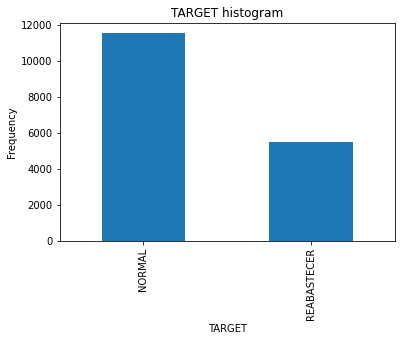

In [4]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(treino['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(treino['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

# Parte 03. Feature Engineering

In [5]:
# Removendo colunas que não serão utilizadas no treinamento
treino = treino.drop(['Tempo','Estacao','Movimentacao','LAT','LONG', 'row'], axis = 1)

# Converte colunas para numerico
treino = treino.apply(pd.to_numeric, errors='ignore')

# Visualizando os primeiros registros
treino.head()

,Original_473,Original_269,Zero,Maca_Verde,Tangerina,Citrus,Acai_Guarana,Pessego,TARGET
0,24,45,61,42,19,22,15,9,NORMAL
1,15,10,10,29,10,25,14,13,NORMAL
2,53,1,55,18,18,6,37,8,REABASTECER
3,36,5,57,38,15,43,43,18,REABASTECER
4,79,10,8,37,32,30,18,15,NORMAL


# Parte 04. Modelagem Preditiva
> - Nesta fase estarei construindo os modelos preditivos
> - Vou utilizar o modelo XGB para treinamento

In [7]:
# Definindo alguns parametros
SEED  = 42

In [8]:
# Selecionando features para treinamento
X = treino.drop(['TARGET'], axis = 1)

# Selecionando feature target
y = treino['TARGET']

# Transformando target em tipo numerico
y = y.astype("category").cat.codes

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X = StandardScaler().fit_transform(X)

# Split dos dados
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = .2, random_state = SEED, stratify = y)

### Sem Balanceamento dos dados

Acurácia: 75.79%
Sensibilidade : 0.6972727272727273
Especificidade : 0.7867998263135041


              precision    recall  f1-score   support

           0       0.84      0.79      0.81      2303
           1       0.61      0.70      0.65      1100

    accuracy                           0.76      3403
   macro avg       0.73      0.74      0.73      3403
weighted avg       0.77      0.76      0.76      3403



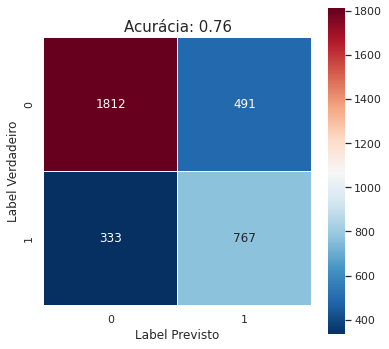

In [9]:
# Criando o modelo
modelo_xgb_v1 = XGBClassifier()

# Treinando o modelo
modelo_xgb_v1.fit(X_treino, y_treino)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v1.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v1 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v1 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v1), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

### Com Balanceamento dos dados

In [10]:
# Aplicando a funcao SMOTE
sm = SMOTE(random_state=0)
X_treino_bal, y_treino_bal = sm.fit_sample(X_treino, y_treino)

Acurácia: 76.26%
Sensibilidade : 0.7263636363636363
Especificidade : 0.7798523664785063


              precision    recall  f1-score   support

           0       0.86      0.78      0.82      2303
           1       0.61      0.73      0.66      1100

    accuracy                           0.76      3403
   macro avg       0.73      0.75      0.74      3403
weighted avg       0.78      0.76      0.77      3403



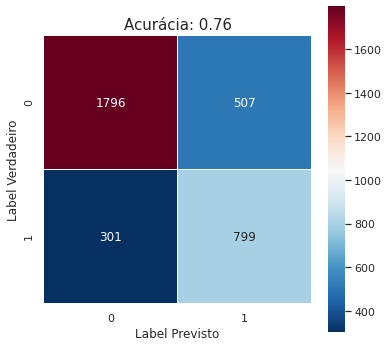

In [11]:
# Criando o modelo
modelo_xgb_v2 = XGBClassifier()

# Treinando o modelo
modelo_xgb_v2.fit(X_treino_bal, y_treino_bal)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v2.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v2 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v2 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v2), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

### Identificando os melhores Hyperparametros

In [12]:
def objective(trial):
    # Selecionando features para treinamento
    X = treino.drop(['TARGET'], axis = 1)

    # Selecionando feature target
    y = treino['TARGET']

    # Transformando target em tipo numerico
    y = y.astype("category").cat.codes

    # Padronizando os dados (0 para a média, 1 para o desvio padrão)
    X = StandardScaler().fit_transform(X)

    # Split dos dados
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = .2, random_state = SEED, stratify = y)    

    dtrain = xgb.DMatrix(X_treino, label=y_treino)
    dvalid = xgb.DMatrix(X_teste, label=y_teste)

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    if param["booster"] == "gbtree" or param["booster"] == "dart":
        param["max_depth"] = trial.suggest_int("max_depth", 1, 9)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
    bst = xgb.train(param, dtrain, evals=[(dvalid, "validation")], callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_teste, pred_labels)
    return accuracy

In [15]:
study_v2 = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=15), direction="maximize")
study_v2.optimize(objective, n_trials=100)
print(study_v2.best_trial)

[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2020-09-10 12:00:19,529] Finished trial#0 with value: 0.6767558037026153 with parameters: {'booster': 'gblinear', 'lambda': 2.2217445004263826e-05, 'alpha': 0.2513925382051475}. Best is trial#0 with value: 0.6767558037026153.


[0]	validation-auc:0.84301
[1]	validation-auc:0.84343
[2]	validation-auc:0.84383
[3]	validation-auc:0.84501
[4]	validation-auc:0.84454
[5]	validation-auc:0.84442
[6]	validation-auc:0.84455
[7]	validation-auc:0.84464
[8]	validation-auc:0.84421
[9]	validation-auc:0.84414


[I 2020-09-10 12:00:19,746] Finished trial#1 with value: 0.7737290625918307 with parameters: {'booster': 'dart', 'lambda': 0.0030666361961162064, 'alpha': 3.909091565221151e-05, 'max_depth': 9, 'eta': 0.0025730292055799976, 'gamma': 9.329571934958972e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.34960830207424853, 'skip_drop': 0.015198364049572439}. Best is trial#1 with value: 0.7737290625918307.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2020-09-10 12:00:19,904] Finished trial#2 with value: 0.6767558037026153 with parameters: {'booster': 'gblinear', 'lambda': 0.00031690051411184224, 'alpha': 0.4068763223975349}. Best is trial#1 with value: 0.7737290625918307.


[0]	validation-auc:0.84301
[1]	validation-auc:0.84447
[2]	validation-auc:0.84567
[3]	validation-auc:0.84649
[4]	validation-auc:0.84663
[5]	validation-auc:0.84416
[6]	validation-auc:0.84387
[7]	validation-auc:0.84467
[8]	validation-auc:0.84384
[9]	validation-auc:0.84355


[I 2020-09-10 12:00:20,116] Finished trial#3 with value: 0.7690273288275051 with parameters: {'booster': 'dart', 'lambda': 7.908264552670721e-05, 'alpha': 0.0007960571080542143, 'max_depth': 9, 'eta': 0.017599738329539063, 'gamma': 0.002518131593351907, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.11704148997946062, 'skip_drop': 9.707329186108238e-06}. Best is trial#1 with value: 0.7737290625918307.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.51258
[5]	validation-auc:0.52090
[6]	validation-auc:0.52412
[7]	validation-auc:0.52743
[8]	validation-auc:0.84122
[9]	validation-auc:0.84150


[I 2020-09-10 12:00:20,325] Finished trial#4 with value: 0.6935057302380253 with parameters: {'booster': 'dart', 'lambda': 1.5192426515849298e-06, 'alpha': 0.05286647511841135, 'max_depth': 8, 'eta': 1.0611723963192535e-08, 'gamma': 1.4443391492327172e-07, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.8879596375935359e-06, 'skip_drop': 0.18117548862798047}. Best is trial#1 with value: 0.7737290625918307.


[0]	validation-auc:0.67627
[1]	validation-auc:0.67649
[2]	validation-auc:0.67665
[3]	validation-auc:0.67674
[4]	validation-auc:0.67682
[5]	validation-auc:0.67688
[6]	validation-auc:0.67690
[7]	validation-auc:0.67692
[8]	validation-auc:0.67693
[9]	validation-auc:0.67694


[I 2020-09-10 12:00:20,484] Finished trial#5 with value: 0.6735233617396414 with parameters: {'booster': 'gblinear', 'lambda': 1.9855618897214644e-05, 'alpha': 3.299737585648839e-06}. Best is trial#1 with value: 0.7737290625918307.


[0]	validation-auc:0.78352
[1]	validation-auc:0.84254
[2]	validation-auc:0.84594
[3]	validation-auc:0.84554
[4]	validation-auc:0.84483
[5]	validation-auc:0.84237
[6]	validation-auc:0.84467
[7]	validation-auc:0.84133
[8]	validation-auc:0.84105
[9]	validation-auc:0.84067


[I 2020-09-10 12:00:20,678] Finished trial#6 with value: 0.7549221275345284 with parameters: {'booster': 'dart', 'lambda': 0.00032328973060901436, 'alpha': 2.7465537694128583e-06, 'max_depth': 6, 'eta': 0.6114660454626598, 'gamma': 0.16415636719382984, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0026296647018120823, 'skip_drop': 0.0009334865059998029}. Best is trial#1 with value: 0.7737290625918307.


[0]	validation-auc:0.81588
[1]	validation-auc:0.81758
[2]	validation-auc:0.81571
[3]	validation-auc:0.81434
[4]	validation-auc:0.81482
[5]	validation-auc:0.81588
[6]	validation-auc:0.81624
[7]	validation-auc:0.81575
[8]	validation-auc:0.81507
[9]	validation-auc:0.81573


[I 2020-09-10 12:00:20,876] Finished trial#7 with value: 0.7716720540699383 with parameters: {'booster': 'dart', 'lambda': 1.692019226864311e-07, 'alpha': 0.013239179014944398, 'max_depth': 7, 'eta': 2.152872758986699e-07, 'gamma': 2.0448798267900026e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 3.9110727344484165e-05, 'skip_drop': 0.0006292077155675255}. Best is trial#1 with value: 0.7737290625918307.


[0]	validation-auc:0.84004
[1]	validation-auc:0.84158
[2]	validation-auc:0.84056
[3]	validation-auc:0.84057
[4]	validation-auc:0.84081
[5]	validation-auc:0.84082
[6]	validation-auc:0.84076
[7]	validation-auc:0.84271
[8]	validation-auc:0.84275
[9]	validation-auc:0.84095


[I 2020-09-10 12:00:21,079] Finished trial#8 with value: 0.7816632383191302 with parameters: {'booster': 'gbtree', 'lambda': 0.0017298771563151172, 'alpha': 8.663085944899583e-05, 'max_depth': 8, 'eta': 6.844960584763693e-06, 'gamma': 2.0817044718455124e-08, 'grow_policy': 'depthwise'}. Best is trial#8 with value: 0.7816632383191302.


[0]	validation-auc:0.67624
[1]	validation-auc:0.67646
[2]	validation-auc:0.67662
[3]	validation-auc:0.67673
[4]	validation-auc:0.67681
[5]	validation-auc:0.67687
[6]	validation-auc:0.67690
[7]	validation-auc:0.67692
[8]	validation-auc:0.67693
[9]	validation-auc:0.67695


[I 2020-09-10 12:00:21,241] Finished trial#9 with value: 0.675580370261534 with parameters: {'booster': 'gblinear', 'lambda': 1.2870834984029296e-07, 'alpha': 0.0005010318099281443}. Best is trial#8 with value: 0.7816632383191302.


[0]	validation-auc:0.72325
[1]	validation-auc:0.72369
[2]	validation-auc:0.72269
[3]	validation-auc:0.72288
[4]	validation-auc:0.72193
[5]	validation-auc:0.72290
[6]	validation-auc:0.72293
[7]	validation-auc:0.72210
[8]	validation-auc:0.72207
[9]	validation-auc:0.72210


[I 2020-09-10 12:00:21,419] Finished trial#10 with value: 0.7490449603291214 with parameters: {'booster': 'gbtree', 'lambda': 0.9989371769421, 'alpha': 1.7850946660314693e-08, 'max_depth': 4, 'eta': 1.554882049182641e-07, 'gamma': 3.241288456510811e-05, 'grow_policy': 'depthwise'}. Best is trial#8 with value: 0.7816632383191302.


[0]	validation-auc:0.78351
[1]	validation-auc:0.84554
[2]	validation-auc:0.84881
[3]	validation-auc:0.84938
[4]	validation-auc:0.84701
[5]	validation-auc:0.85135
[6]	validation-auc:0.85091
[7]	validation-auc:0.84983
[8]	validation-auc:0.84783
[9]	validation-auc:0.85032


[I 2020-09-10 12:00:21,610] Finished trial#11 with value: 0.766382603585072 with parameters: {'booster': 'gbtree', 'lambda': 0.03578134184790828, 'alpha': 1.1655875811996408e-05, 'max_depth': 6, 'eta': 0.21856791268744843, 'gamma': 0.00019593542474578967, 'grow_policy': 'depthwise'}. Best is trial#8 with value: 0.7816632383191302.


[0]	validation-auc:0.83875
[1]	validation-auc:0.83896
[2]	validation-auc:0.83867
[3]	validation-auc:0.83817
[4]	validation-auc:0.83838
[5]	validation-auc:0.84285
[6]	validation-auc:0.84289
[7]	validation-auc:0.84264
[8]	validation-auc:0.84184
[9]	validation-auc:0.84282


[I 2020-09-10 12:00:21,822] Finished trial#12 with value: 0.7728474875110197 with parameters: {'booster': 'gbtree', 'lambda': 0.01414301807602312, 'alpha': 9.781701539645922e-08, 'max_depth': 9, 'eta': 1.446771845471391e-06, 'gamma': 0.9395836918080618, 'grow_policy': 'depthwise'}. Best is trial#8 with value: 0.7816632383191302.


[0]	validation-auc:0.72272
[1]	validation-auc:0.72272
[2]	validation-auc:0.72272
[3]	validation-auc:0.72272
[4]	validation-auc:0.72272
[5]	validation-auc:0.72272
[6]	validation-auc:0.72272
[7]	validation-auc:0.72272
[8]	validation-auc:0.72272
[9]	validation-auc:0.72272


[I 2020-09-10 12:00:22,000] Finished trial#13 with value: 0.7508081104907435 with parameters: {'booster': 'gbtree', 'lambda': 0.00843310167250817, 'alpha': 5.530128636500943e-05, 'max_depth': 4, 'eta': 0.0005545297102729199, 'gamma': 0.01667957755088911, 'grow_policy': 'lossguide'}. Best is trial#8 with value: 0.7816632383191302.


[0]	validation-auc:0.62377
[1]	validation-auc:0.62377
[2]	validation-auc:0.62377
[3]	validation-auc:0.62377
[4]	validation-auc:0.62377
[5]	validation-auc:0.62377
[6]	validation-auc:0.62377
[7]	validation-auc:0.62377
[8]	validation-auc:0.62377
[9]	validation-auc:0.62377


[I 2020-09-10 12:00:22,178] Finished trial#14 with value: 0.7190714075815456 with parameters: {'booster': 'dart', 'lambda': 0.3379504808566445, 'alpha': 3.4859687455565507e-07, 'max_depth': 2, 'eta': 2.0256444853421434e-05, 'gamma': 3.1840287690705676e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0074850157281874975, 'skip_drop': 0.0002775308772545892}. Best is trial#8 with value: 0.7816632383191302.


[0]	validation-auc:0.84303
[1]	validation-auc:0.84349
[2]	validation-auc:0.84409
[3]	validation-auc:0.84397
[4]	validation-auc:0.84413
[5]	validation-auc:0.84399
[6]	validation-auc:0.84425
[7]	validation-auc:0.84414
[8]	validation-auc:0.84426
[9]	validation-auc:0.84417


[I 2020-09-10 12:00:22,394] Finished trial#15 with value: 0.7749044960329121 with parameters: {'booster': 'gbtree', 'lambda': 0.0022687837040791764, 'alpha': 0.001908165585464287, 'max_depth': 9, 'eta': 0.0005297407121017332, 'gamma': 1.1833392793058643e-08, 'grow_policy': 'lossguide'}. Best is trial#8 with value: 0.7816632383191302.


[0]	validation-auc:0.84243
[1]	validation-auc:0.84273
[2]	validation-auc:0.84284
[3]	validation-auc:0.84291
[4]	validation-auc:0.84287
[5]	validation-auc:0.84294
[6]	validation-auc:0.84304
[7]	validation-auc:0.84298
[8]	validation-auc:0.84296
[9]	validation-auc:0.84310


[I 2020-09-10 12:00:22,604] Finished trial#16 with value: 0.7816632383191302 with parameters: {'booster': 'gbtree', 'lambda': 0.15164244572695695, 'alpha': 0.0011943516034667201, 'max_depth': 8, 'eta': 1.5005375250478673e-05, 'gamma': 1.901564100542203e-06, 'grow_policy': 'lossguide'}. Best is trial#8 with value: 0.7816632383191302.


[0]	validation-auc:0.81624
[1]	validation-auc:0.81647
[2]	validation-auc:0.81597
[3]	validation-auc:0.81607
[4]	validation-auc:0.81594
[5]	validation-auc:0.81608
[6]	validation-auc:0.81596
[7]	validation-auc:0.81607
[8]	validation-auc:0.81599
[9]	validation-auc:0.81608


[I 2020-09-10 12:00:22,807] Finished trial#17 with value: 0.7719659124302086 with parameters: {'booster': 'gbtree', 'lambda': 0.13390228060293585, 'alpha': 0.007973246340733924, 'max_depth': 7, 'eta': 1.3016428247464781e-05, 'gamma': 1.680695767306637e-06, 'grow_policy': 'lossguide'}. Best is trial#8 with value: 0.7816632383191302.


[0]	validation-auc:0.81988
[1]	validation-auc:0.81998
[2]	validation-auc:0.81924
[3]	validation-auc:0.82004
[4]	validation-auc:0.81991
[5]	validation-auc:0.82004
[6]	validation-auc:0.81988
[7]	validation-auc:0.81997
[8]	validation-auc:0.81988
[9]	validation-auc:0.81997


[I 2020-09-10 12:00:23,010] Finished trial#18 with value: 0.7710843373493976 with parameters: {'booster': 'gbtree', 'lambda': 0.22589367939918137, 'alpha': 0.0002830799423543451, 'max_depth': 7, 'eta': 7.231223422908506e-06, 'gamma': 9.124618845036454e-07, 'grow_policy': 'lossguide'}. Best is trial#8 with value: 0.7816632383191302.


[0]	validation-auc:0.75038
[1]	validation-auc:0.74947
[2]	validation-auc:0.74945
[3]	validation-auc:0.74954
[4]	validation-auc:0.75119
[5]	validation-auc:0.75127
[6]	validation-auc:0.74995
[7]	validation-auc:0.75000
[8]	validation-auc:0.74995
[9]	validation-auc:0.74994


[I 2020-09-10 12:00:23,199] Finished trial#19 with value: 0.7508081104907435 with parameters: {'booster': 'gbtree', 'lambda': 0.0009944146589807134, 'alpha': 0.005296751289632308, 'max_depth': 5, 'eta': 5.617333701629763e-07, 'gamma': 1.9708481194462872e-05, 'grow_policy': 'lossguide'}. Best is trial#8 with value: 0.7816632383191302.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.51258
[5]	validation-auc:0.52090
[6]	validation-auc:0.52343
[7]	validation-auc:0.53298
[8]	validation-auc:0.84122
[9]	validation-auc:0.84150


[I 2020-09-10 12:00:23,410] Finished trial#20 with value: 0.6935057302380253 with parameters: {'booster': 'gbtree', 'lambda': 0.058548414747996394, 'alpha': 0.00016435954692208858, 'max_depth': 8, 'eta': 1.066881289699224e-08, 'gamma': 1.5927495278937948e-07, 'grow_policy': 'lossguide'}. Best is trial#8 with value: 0.7816632383191302.


[0]	validation-auc:0.84249
[1]	validation-auc:0.84259
[2]	validation-auc:0.84305
[3]	validation-auc:0.84314
[4]	validation-auc:0.84347
[5]	validation-auc:0.84352
[6]	validation-auc:0.84369
[7]	validation-auc:0.84372
[8]	validation-auc:0.84384
[9]	validation-auc:0.84395


[I 2020-09-10 12:00:23,657] Finished trial#21 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.0020661863695123463, 'alpha': 0.0017191105638233925, 'max_depth': 8, 'eta': 0.00010549629126557829, 'gamma': 1.400153490460652e-08, 'grow_policy': 'depthwise'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.62377
[1]	validation-auc:0.62377
[2]	validation-auc:0.62377
[3]	validation-auc:0.62377
[4]	validation-auc:0.62377
[5]	validation-auc:0.62377
[6]	validation-auc:0.62377
[7]	validation-auc:0.62377
[8]	validation-auc:0.62377
[9]	validation-auc:0.62377


[I 2020-09-10 12:00:23,870] Finished trial#22 with value: 0.7190714075815456 with parameters: {'booster': 'gbtree', 'lambda': 0.009417316101211316, 'alpha': 0.057587758939553035, 'max_depth': 2, 'eta': 0.00015594204959694732, 'gamma': 0.00018590520455593433, 'grow_policy': 'depthwise'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.78352
[1]	validation-auc:0.81521
[2]	validation-auc:0.81673
[3]	validation-auc:0.84664
[4]	validation-auc:0.84654
[5]	validation-auc:0.84667
[6]	validation-auc:0.84818
[7]	validation-auc:0.84996
[8]	validation-auc:0.84900
[9]	validation-auc:0.85004


[I 2020-09-10 12:00:24,067] Finished trial#23 with value: 0.7593300029385835 with parameters: {'booster': 'gbtree', 'lambda': 0.0005856196369710773, 'alpha': 0.0017634004408938811, 'max_depth': 6, 'eta': 0.034747029302797695, 'gamma': 1.7485523051104934e-08, 'grow_policy': 'depthwise'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.75113
[1]	validation-auc:0.75113
[2]	validation-auc:0.75113
[3]	validation-auc:0.75113
[4]	validation-auc:0.75113
[5]	validation-auc:0.75113
[6]	validation-auc:0.75113
[7]	validation-auc:0.75113
[8]	validation-auc:0.75113
[9]	validation-auc:0.75113


[I 2020-09-10 12:00:24,259] Finished trial#24 with value: 0.7508081104907435 with parameters: {'booster': 'gbtree', 'lambda': 5.0155282338839953e-05, 'alpha': 1.8363610171400548e-05, 'max_depth': 5, 'eta': 8.056799502782728e-05, 'gamma': 1.0838560519809554e-08, 'grow_policy': 'depthwise'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.84028
[1]	validation-auc:0.84018
[2]	validation-auc:0.84069
[3]	validation-auc:0.84089
[4]	validation-auc:0.84074
[5]	validation-auc:0.84078
[6]	validation-auc:0.84089
[7]	validation-auc:0.84092
[8]	validation-auc:0.84101
[9]	validation-auc:0.84104


[I 2020-09-10 12:00:24,469] Finished trial#25 with value: 0.7816632383191302 with parameters: {'booster': 'gbtree', 'lambda': 6.411882213971759e-06, 'alpha': 9.570396076444885e-05, 'max_depth': 8, 'eta': 2.7371877979826085e-06, 'gamma': 3.263626931153604e-07, 'grow_policy': 'depthwise'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.83973
[1]	validation-auc:0.83899
[2]	validation-auc:0.83938
[3]	validation-auc:0.83986
[4]	validation-auc:0.84002
[5]	validation-auc:0.84020
[6]	validation-auc:0.84003
[7]	validation-auc:0.84218
[8]	validation-auc:0.84194
[9]	validation-auc:0.84221


[I 2020-09-10 12:00:24,681] Finished trial#26 with value: 0.7816632383191302 with parameters: {'booster': 'gbtree', 'lambda': 2.1404055532309245e-06, 'alpha': 0.035461464935181645, 'max_depth': 8, 'eta': 1.4423406534049371e-06, 'gamma': 6.411285690281767e-07, 'grow_policy': 'depthwise'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.50815
[1]	validation-auc:0.81738
[2]	validation-auc:0.81601
[3]	validation-auc:0.81534
[4]	validation-auc:0.81316
[5]	validation-auc:0.81129
[6]	validation-auc:0.81502
[7]	validation-auc:0.81700
[8]	validation-auc:0.81586
[9]	validation-auc:0.81494


[I 2020-09-10 12:00:24,884] Finished trial#27 with value: 0.7710843373493976 with parameters: {'booster': 'gbtree', 'lambda': 2.7733754340000365e-06, 'alpha': 0.049189013110864044, 'max_depth': 7, 'eta': 5.731674285730501e-08, 'gamma': 6.889611729289e-06, 'grow_policy': 'depthwise'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.83995
[1]	validation-auc:0.84007
[2]	validation-auc:0.84051
[3]	validation-auc:0.84076
[4]	validation-auc:0.84081
[5]	validation-auc:0.84108
[6]	validation-auc:0.84104
[7]	validation-auc:0.84121
[8]	validation-auc:0.84133
[9]	validation-auc:0.84159


[I 2020-09-10 12:00:25,096] Finished trial#28 with value: 0.7828386717602116 with parameters: {'booster': 'gbtree', 'lambda': 2.2767918445760882e-08, 'alpha': 3.7180071854042066e-06, 'max_depth': 8, 'eta': 5.3942498429121096e-05, 'gamma': 8.588881747047252e-08, 'grow_policy': 'lossguide'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.50000
[1]	validation-auc:0.50000
[2]	validation-auc:0.50000
[3]	validation-auc:0.50000
[4]	validation-auc:0.50000
[5]	validation-auc:0.50000
[6]	validation-auc:0.50000
[7]	validation-auc:0.50000
[8]	validation-auc:0.50000
[9]	validation-auc:0.50000


[I 2020-09-10 12:00:25,264] Finished trial#29 with value: 0.6767558037026153 with parameters: {'booster': 'gblinear', 'lambda': 1.684023271979721e-08, 'alpha': 0.1303753279024675}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.83699
[1]	validation-auc:0.84259
[2]	validation-auc:0.83693
[3]	validation-auc:0.83805
[4]	validation-auc:0.83868
[5]	validation-auc:0.84299
[6]	validation-auc:0.83926
[7]	validation-auc:0.83910
[8]	validation-auc:0.84065
[9]	validation-auc:0.84344


[I 2020-09-10 12:00:25,513] Finished trial#30 with value: 0.7746106376726418 with parameters: {'booster': 'gbtree', 'lambda': 0.00019093779488774974, 'alpha': 1.46597992184379e-06, 'max_depth': 9, 'eta': 7.001444959054575e-05, 'gamma': 5.9322190230655695e-08, 'grow_policy': 'depthwise'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.82418
[1]	validation-auc:0.82465
[2]	validation-auc:0.82498
[3]	validation-auc:0.82467
[4]	validation-auc:0.82472
[5]	validation-auc:0.82468
[6]	validation-auc:0.82465
[7]	validation-auc:0.82468
[8]	validation-auc:0.82463
[9]	validation-auc:0.82469


[I 2020-09-10 12:00:25,719] Finished trial#31 with value: 0.766382603585072 with parameters: {'booster': 'gbtree', 'lambda': 7.301087322716522e-06, 'alpha': 0.8652905165276189, 'max_depth': 7, 'eta': 0.0010762067584119584, 'gamma': 6.203620223550693e-06, 'grow_policy': 'lossguide'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.78352
[1]	validation-auc:0.78482
[2]	validation-auc:0.78429
[3]	validation-auc:0.78483
[4]	validation-auc:0.78425
[5]	validation-auc:0.81467
[6]	validation-auc:0.81424
[7]	validation-auc:0.81429
[8]	validation-auc:0.81423
[9]	validation-auc:0.81484


[I 2020-09-10 12:00:25,918] Finished trial#32 with value: 0.753746694093447 with parameters: {'booster': 'gbtree', 'lambda': 5.729691393272451e-07, 'alpha': 2.1854257781235385e-05, 'max_depth': 6, 'eta': 0.003967140577136426, 'gamma': 4.3244772115455554e-07, 'grow_policy': 'depthwise'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.84247
[1]	validation-auc:0.84168
[2]	validation-auc:0.84052
[3]	validation-auc:0.84292
[4]	validation-auc:0.84201
[5]	validation-auc:0.84314
[6]	validation-auc:0.84268
[7]	validation-auc:0.84324
[8]	validation-auc:0.84295
[9]	validation-auc:0.84344


[I 2020-09-10 12:00:26,131] Finished trial#33 with value: 0.7828386717602116 with parameters: {'booster': 'gbtree', 'lambda': 1.1594484493201563e-08, 'alpha': 0.0019420118722632373, 'max_depth': 8, 'eta': 5.803406424245741e-05, 'gamma': 5.201288953231909e-08, 'grow_policy': 'depthwise'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.84213
[1]	validation-auc:0.84224
[2]	validation-auc:0.84302
[3]	validation-auc:0.84324
[4]	validation-auc:0.84343
[5]	validation-auc:0.84352
[6]	validation-auc:0.84359
[7]	validation-auc:0.84373
[8]	validation-auc:0.84381
[9]	validation-auc:0.84362


[I 2020-09-10 12:00:26,350] Finished trial#34 with value: 0.7749044960329121 with parameters: {'booster': 'gbtree', 'lambda': 1.0450235930458876e-08, 'alpha': 0.004420676085868813, 'max_depth': 9, 'eta': 0.0001521144873270729, 'gamma': 4.939471624945016e-08, 'grow_policy': 'lossguide'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.72272
[1]	validation-auc:0.72272
[2]	validation-auc:0.72272
[3]	validation-auc:0.72272
[4]	validation-auc:0.72214
[5]	validation-auc:0.72228
[6]	validation-auc:0.72212
[7]	validation-auc:0.72200
[8]	validation-auc:0.75388
[9]	validation-auc:0.79325


[I 2020-09-10 12:00:26,537] Finished trial#35 with value: 0.7472818101674993 with parameters: {'booster': 'gbtree', 'lambda': 3.0044038045476e-08, 'alpha': 0.016704769537731593, 'max_depth': 4, 'eta': 0.006053379090349309, 'gamma': 6.785329363124655e-08, 'grow_policy': 'lossguide'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.67627
[1]	validation-auc:0.67649
[2]	validation-auc:0.67665
[3]	validation-auc:0.67674
[4]	validation-auc:0.67682
[5]	validation-auc:0.67688
[6]	validation-auc:0.67689
[7]	validation-auc:0.67692
[8]	validation-auc:0.67693
[9]	validation-auc:0.67694


[I 2020-09-10 12:00:26,704] Finished trial#36 with value: 0.6735233617396414 with parameters: {'booster': 'gblinear', 'lambda': 5.39720359430922e-08, 'alpha': 7.961067941184844e-06}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.84193
[1]	validation-auc:0.84209
[2]	validation-auc:0.84230
[3]	validation-auc:0.84217
[4]	validation-auc:0.84217
[5]	validation-auc:0.84232
[6]	validation-auc:0.84225
[7]	validation-auc:0.84228
[8]	validation-auc:0.84241
[9]	validation-auc:0.84248


[I 2020-09-10 12:00:26,917] Finished trial#37 with value: 0.7813693799588598 with parameters: {'booster': 'gbtree', 'lambda': 4.038455150462452e-07, 'alpha': 0.1585732762986274, 'max_depth': 8, 'eta': 3.807837814683577e-05, 'gamma': 3.3733168780494546e-07, 'grow_policy': 'depthwise'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.83702
[1]	validation-auc:0.83668
[2]	validation-auc:0.84161
[3]	validation-auc:0.83734
[4]	validation-auc:0.83812
[5]	validation-auc:0.83735
[6]	validation-auc:0.83744
[7]	validation-auc:0.84148
[8]	validation-auc:0.83748
[9]	validation-auc:0.83909


[I 2020-09-10 12:00:27,138] Finished trial#38 with value: 0.7725536291507493 with parameters: {'booster': 'gbtree', 'lambda': 0.0021667003041015665, 'alpha': 7.231351548605469e-07, 'max_depth': 9, 'eta': 5.140265893452613e-06, 'gamma': 1.0054007999881167e-08, 'grow_policy': 'depthwise'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.84807
[1]	validation-auc:0.84802
[2]	validation-auc:0.84798
[3]	validation-auc:0.84810
[4]	validation-auc:0.84805
[5]	validation-auc:0.84789
[6]	validation-auc:0.84806
[7]	validation-auc:0.84805
[8]	validation-auc:0.84803
[9]	validation-auc:0.84811


[I 2020-09-10 12:00:27,356] Finished trial#39 with value: 0.7787246547164267 with parameters: {'booster': 'dart', 'lambda': 0.9449288356715015, 'alpha': 0.001068148163577997, 'max_depth': 8, 'eta': 4.345011014910684e-05, 'gamma': 3.6074030876938047e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.020591910385404512, 'skip_drop': 2.9343123224827496e-07}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.67625
[1]	validation-auc:0.67646
[2]	validation-auc:0.67663
[3]	validation-auc:0.67673
[4]	validation-auc:0.67682
[5]	validation-auc:0.67688
[6]	validation-auc:0.67691
[7]	validation-auc:0.67692
[8]	validation-auc:0.67693
[9]	validation-auc:0.67695


[I 2020-09-10 12:00:27,523] Finished trial#40 with value: 0.6746987951807228 with parameters: {'booster': 'gblinear', 'lambda': 1.8767928572981885e-05, 'alpha': 0.00025997882061814495}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.81435
[1]	validation-auc:0.81458
[2]	validation-auc:0.81483
[3]	validation-auc:0.81635
[4]	validation-auc:0.81624
[5]	validation-auc:0.81638
[6]	validation-auc:0.81641
[7]	validation-auc:0.81640
[8]	validation-auc:0.81633
[9]	validation-auc:0.81641


[I 2020-09-10 12:00:27,729] Finished trial#41 with value: 0.772259770790479 with parameters: {'booster': 'gbtree', 'lambda': 2.446729152653732e-06, 'alpha': 0.02023413471231377, 'max_depth': 7, 'eta': 0.00025858685632153597, 'gamma': 1.3176197081855221e-07, 'grow_policy': 'depthwise'}. Best is trial#21 with value: 0.7831325301204819.


[0]	validation-auc:0.84269
[1]	validation-auc:0.84362
[2]	validation-auc:0.84393
[3]	validation-auc:0.84378
[4]	validation-auc:0.84411
[5]	validation-auc:0.84397
[6]	validation-auc:0.84411
[7]	validation-auc:0.84400
[8]	validation-auc:0.84423
[9]	validation-auc:0.84404


[I 2020-09-10 12:00:27,944] Finished trial#42 with value: 0.7834263884807523 with parameters: {'booster': 'gbtree', 'lambda': 0.026834336727892413, 'alpha': 0.0006039910566283139, 'max_depth': 8, 'eta': 0.0006565933008274129, 'gamma': 0.0012661208934645076, 'grow_policy': 'depthwise'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84294
[1]	validation-auc:0.84339
[2]	validation-auc:0.84403
[3]	validation-auc:0.84365
[4]	validation-auc:0.84369
[5]	validation-auc:0.84407
[6]	validation-auc:0.84430
[7]	validation-auc:0.84466
[8]	validation-auc:0.84448
[9]	validation-auc:0.84460


[I 2020-09-10 12:00:28,164] Finished trial#43 with value: 0.7740229209521011 with parameters: {'booster': 'gbtree', 'lambda': 0.02583707968898521, 'alpha': 0.0005741299119949087, 'max_depth': 9, 'eta': 0.0013488962279835947, 'gamma': 0.0009271441350499355, 'grow_policy': 'depthwise'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.57006
[1]	validation-auc:0.57006
[2]	validation-auc:0.57006
[3]	validation-auc:0.57006
[4]	validation-auc:0.57006
[5]	validation-auc:0.57006
[6]	validation-auc:0.57006
[7]	validation-auc:0.57006
[8]	validation-auc:0.57006
[9]	validation-auc:0.57006


[I 2020-09-10 12:00:28,342] Finished trial#44 with value: 0.7005583308845137 with parameters: {'booster': 'gbtree', 'lambda': 1.0235176922383707e-07, 'alpha': 0.0026675419802945142, 'max_depth': 1, 'eta': 0.00033217234809516477, 'gamma': 0.01564832509436586, 'grow_policy': 'depthwise'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84249
[1]	validation-auc:0.84321
[2]	validation-auc:0.84309
[3]	validation-auc:0.84301
[4]	validation-auc:0.84330
[5]	validation-auc:0.84555
[6]	validation-auc:0.84670
[7]	validation-auc:0.84650
[8]	validation-auc:0.84678
[9]	validation-auc:0.84640


[I 2020-09-10 12:00:28,556] Finished trial#45 with value: 0.7757860711137232 with parameters: {'booster': 'gbtree', 'lambda': 0.00013180175914847682, 'alpha': 0.00013409840385975773, 'max_depth': 8, 'eta': 0.025187840337240624, 'gamma': 0.0022277970514568203, 'grow_policy': 'depthwise'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.82197
[1]	validation-auc:0.82245
[2]	validation-auc:0.82232
[3]	validation-auc:0.82246
[4]	validation-auc:0.82233
[5]	validation-auc:0.82261
[6]	validation-auc:0.84801
[7]	validation-auc:0.84813
[8]	validation-auc:0.84779
[9]	validation-auc:0.84796


[I 2020-09-10 12:00:28,767] Finished trial#46 with value: 0.7728474875110197 with parameters: {'booster': 'dart', 'lambda': 0.0051483906335819075, 'alpha': 0.4266892108279611, 'max_depth': 7, 'eta': 0.0066889747672043915, 'gamma': 0.0008063669625544101, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 7.181241518377497e-07, 'skip_drop': 0.0013430567063720783}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.78352
[1]	validation-auc:0.78351
[2]	validation-auc:0.78429
[3]	validation-auc:0.78392
[4]	validation-auc:0.78425
[5]	validation-auc:0.78429
[6]	validation-auc:0.78425
[7]	validation-auc:0.78424
[8]	validation-auc:0.78471
[9]	validation-auc:0.78429


[I 2020-09-10 12:00:28,966] Finished trial#47 with value: 0.7655010285042609 with parameters: {'booster': 'gbtree', 'lambda': 5.090183932665647e-07, 'alpha': 3.9364588766102235e-05, 'max_depth': 6, 'eta': 0.001758478805773359, 'gamma': 0.029121569112249723, 'grow_policy': 'depthwise'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.83870
[1]	validation-auc:0.84136
[2]	validation-auc:0.84169
[3]	validation-auc:0.84193
[4]	validation-auc:0.84198
[5]	validation-auc:0.84229
[6]	validation-auc:0.84237
[7]	validation-auc:0.84235
[8]	validation-auc:0.84244
[9]	validation-auc:0.84251


[I 2020-09-10 12:00:29,181] Finished trial#48 with value: 0.7813693799588598 with parameters: {'booster': 'gbtree', 'lambda': 0.08593617157282485, 'alpha': 0.001129051587676012, 'max_depth': 8, 'eta': 1.1910835304060128e-06, 'gamma': 6.72983306641561e-05, 'grow_policy': 'depthwise'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.83700
[1]	validation-auc:0.83699
[2]	validation-auc:0.83702
[3]	validation-auc:0.83720
[4]	validation-auc:0.83755
[5]	validation-auc:0.83745
[6]	validation-auc:0.83747
[7]	validation-auc:0.83906
[8]	validation-auc:0.84271
[9]	validation-auc:0.84197


[I 2020-09-10 12:00:29,402] Finished trial#49 with value: 0.77314134587129 with parameters: {'booster': 'gbtree', 'lambda': 4.732170613647461e-08, 'alpha': 0.000520452324672002, 'max_depth': 9, 'eta': 2.76164709582449e-05, 'gamma': 2.4827769965776225e-08, 'grow_policy': 'depthwise'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84494
[1]	validation-auc:0.84554
[2]	validation-auc:0.84554
[3]	validation-auc:0.84561
[4]	validation-auc:0.84575
[5]	validation-auc:0.84560
[6]	validation-auc:0.84562
[7]	validation-auc:0.84566
[8]	validation-auc:0.84568
[9]	validation-auc:0.84569


[I 2020-09-10 12:00:29,617] Finished trial#50 with value: 0.7810755215985895 with parameters: {'booster': 'gbtree', 'lambda': 0.4198776950291004, 'alpha': 7.918828940263193e-08, 'max_depth': 8, 'eta': 3.9762415615452805e-06, 'gamma': 1.9864977002816266e-07, 'grow_policy': 'depthwise'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.81436
[1]	validation-auc:0.81611
[2]	validation-auc:0.81650
[3]	validation-auc:0.81641
[4]	validation-auc:0.81561
[5]	validation-auc:0.81576
[6]	validation-auc:0.81579
[7]	validation-auc:0.81585
[8]	validation-auc:0.81576
[9]	validation-auc:0.81600


[I 2020-09-10 12:00:29,824] Finished trial#51 with value: 0.772259770790479 with parameters: {'booster': 'gbtree', 'lambda': 3.772606635829969e-05, 'alpha': 8.777363586030221e-05, 'max_depth': 7, 'eta': 0.0008101709714425844, 'gamma': 0.00047680292485774976, 'grow_policy': 'depthwise'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.83709
[1]	validation-auc:0.83910
[2]	validation-auc:0.83811
[3]	validation-auc:0.84254
[4]	validation-auc:0.83742
[5]	validation-auc:0.83750
[6]	validation-auc:0.83839
[7]	validation-auc:0.84152
[8]	validation-auc:0.84249
[9]	validation-auc:0.84251


[I 2020-09-10 12:00:30,046] Finished trial#52 with value: 0.7725536291507493 with parameters: {'booster': 'gbtree', 'lambda': 9.085421974907062e-06, 'alpha': 0.0034767762610762375, 'max_depth': 9, 'eta': 1.3556972262665069e-05, 'gamma': 1.5650250153719902e-06, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84246
[1]	validation-auc:0.84263
[2]	validation-auc:0.84279
[3]	validation-auc:0.84300
[4]	validation-auc:0.84320
[5]	validation-auc:0.84339
[6]	validation-auc:0.84361
[7]	validation-auc:0.84370
[8]	validation-auc:0.84392
[9]	validation-auc:0.84393


[I 2020-09-10 12:00:30,265] Finished trial#53 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.015686082434077472, 'alpha': 4.459028378273658e-06, 'max_depth': 8, 'eta': 0.00010267027689246804, 'gamma': 0.007617016553337403, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.81436
[1]	validation-auc:0.81458
[2]	validation-auc:0.81481
[3]	validation-auc:0.81635
[4]	validation-auc:0.81623
[5]	validation-auc:0.81639
[6]	validation-auc:0.81642
[7]	validation-auc:0.81640
[8]	validation-auc:0.81644
[9]	validation-auc:0.81641


[I 2020-09-10 12:00:30,473] Finished trial#54 with value: 0.772259770790479 with parameters: {'booster': 'gbtree', 'lambda': 0.01909375593722611, 'alpha': 2.8569214674953e-06, 'max_depth': 7, 'eta': 0.00021789042654200898, 'gamma': 0.006133972776217732, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84204
[1]	validation-auc:0.84260
[2]	validation-auc:0.84255
[3]	validation-auc:0.84270
[4]	validation-auc:0.84297
[5]	validation-auc:0.84303
[6]	validation-auc:0.84344
[7]	validation-auc:0.84335
[8]	validation-auc:0.84358
[9]	validation-auc:0.84351


[I 2020-09-10 12:00:30,695] Finished trial#55 with value: 0.7751983543931825 with parameters: {'booster': 'gbtree', 'lambda': 0.005188065394997649, 'alpha': 6.06059118880759e-06, 'max_depth': 9, 'eta': 7.943280316104918e-05, 'gamma': 0.10703461118584476, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84218
[1]	validation-auc:0.84313
[2]	validation-auc:0.84374
[3]	validation-auc:0.84393
[4]	validation-auc:0.84432
[5]	validation-auc:0.84398
[6]	validation-auc:0.84414
[7]	validation-auc:0.84381
[8]	validation-auc:0.84391
[9]	validation-auc:0.84388


[I 2020-09-10 12:00:30,908] Finished trial#56 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.0008098152441452987, 'alpha': 1.931592762460032e-07, 'max_depth': 8, 'eta': 0.0004966493646231682, 'gamma': 0.0028143637120221685, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84249
[1]	validation-auc:0.84050
[2]	validation-auc:0.84342
[3]	validation-auc:0.84629
[4]	validation-auc:0.84584
[5]	validation-auc:0.84689
[6]	validation-auc:0.84562
[7]	validation-auc:0.84574
[8]	validation-auc:0.84626
[9]	validation-auc:0.84717


[I 2020-09-10 12:00:31,126] Finished trial#57 with value: 0.7760799294739935 with parameters: {'booster': 'dart', 'lambda': 0.0008896024406076558, 'alpha': 2.614580161658313e-07, 'max_depth': 8, 'eta': 0.06912222291478654, 'gamma': 0.0029732312386713203, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.15613944422195564, 'skip_drop': 0.4144510103911857}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84244
[1]	validation-auc:0.84309
[2]	validation-auc:0.84400
[3]	validation-auc:0.84393
[4]	validation-auc:0.84415
[5]	validation-auc:0.84386
[6]	validation-auc:0.84400
[7]	validation-auc:0.84382
[8]	validation-auc:0.84391
[9]	validation-auc:0.84387


[I 2020-09-10 12:00:31,339] Finished trial#58 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.00033901332636042343, 'alpha': 7.739722547683418e-08, 'max_depth': 8, 'eta': 0.000519425070343721, 'gamma': 0.05988943584128761, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84245
[1]	validation-auc:0.84311
[2]	validation-auc:0.84376
[3]	validation-auc:0.84393
[4]	validation-auc:0.84429
[5]	validation-auc:0.84396
[6]	validation-auc:0.84414
[7]	validation-auc:0.84378
[8]	validation-auc:0.84394
[9]	validation-auc:0.84382


[I 2020-09-10 12:00:31,555] Finished trial#59 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.0006534795794392122, 'alpha': 1.3027477312455685e-08, 'max_depth': 8, 'eta': 0.00047503749154280666, 'gamma': 0.14930340673812192, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.67627
[1]	validation-auc:0.67649
[2]	validation-auc:0.67665
[3]	validation-auc:0.67674
[4]	validation-auc:0.67682
[5]	validation-auc:0.67688
[6]	validation-auc:0.67689
[7]	validation-auc:0.67692
[8]	validation-auc:0.67694
[9]	validation-auc:0.67694


[I 2020-09-10 12:00:31,726] Finished trial#60 with value: 0.6738172200999119 with parameters: {'booster': 'gblinear', 'lambda': 0.00037161283703496847, 'alpha': 1.8239388529944496e-08}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.81562
[1]	validation-auc:0.81609
[2]	validation-auc:0.81616
[3]	validation-auc:0.81636
[4]	validation-auc:0.81582
[5]	validation-auc:0.81574
[6]	validation-auc:0.81563
[7]	validation-auc:0.81575
[8]	validation-auc:0.81578
[9]	validation-auc:0.81575


[I 2020-09-10 12:00:31,933] Finished trial#61 with value: 0.772259770790479 with parameters: {'booster': 'gbtree', 'lambda': 0.0012181761233036334, 'alpha': 1.109451729748113e-08, 'max_depth': 7, 'eta': 0.0005329795182727056, 'gamma': 0.8093109711377378, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84302
[1]	validation-auc:0.84341
[2]	validation-auc:0.84516
[3]	validation-auc:0.84401
[4]	validation-auc:0.84526
[5]	validation-auc:0.84457
[6]	validation-auc:0.84496
[7]	validation-auc:0.84524
[8]	validation-auc:0.84515
[9]	validation-auc:0.84475


[I 2020-09-10 12:00:32,153] Finished trial#62 with value: 0.7746106376726418 with parameters: {'booster': 'gbtree', 'lambda': 0.0004335988265831388, 'alpha': 4.588324520747169e-08, 'max_depth': 9, 'eta': 0.003619352935133568, 'gamma': 0.17927961609277274, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84249
[1]	validation-auc:0.84359
[2]	validation-auc:0.84371
[3]	validation-auc:0.84452
[4]	validation-auc:0.84435
[5]	validation-auc:0.84343
[6]	validation-auc:0.84387
[7]	validation-auc:0.84301
[8]	validation-auc:0.84347
[9]	validation-auc:0.84258


[I 2020-09-10 12:00:32,368] Finished trial#63 with value: 0.7775492212753453 with parameters: {'booster': 'gbtree', 'lambda': 0.0035756457712892973, 'alpha': 2.373901031704243e-07, 'max_depth': 8, 'eta': 0.011808862015568111, 'gamma': 0.07715764531639406, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.78352
[1]	validation-auc:0.78358
[2]	validation-auc:0.78358
[3]	validation-auc:0.78358
[4]	validation-auc:0.78352
[5]	validation-auc:0.78352
[6]	validation-auc:0.78356
[7]	validation-auc:0.78356
[8]	validation-auc:0.78392
[9]	validation-auc:0.78371


[I 2020-09-10 12:00:32,569] Finished trial#64 with value: 0.7655010285042609 with parameters: {'booster': 'gbtree', 'lambda': 0.00017819545640274356, 'alpha': 3.2459647239975496e-08, 'max_depth': 6, 'eta': 0.0004670741139150356, 'gamma': 0.04119075896544327, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84249
[1]	validation-auc:0.84343
[2]	validation-auc:0.84324
[3]	validation-auc:0.84371
[4]	validation-auc:0.84399
[5]	validation-auc:0.84388
[6]	validation-auc:0.84387
[7]	validation-auc:0.84434
[8]	validation-auc:0.84401
[9]	validation-auc:0.84400


[I 2020-09-10 12:00:32,786] Finished trial#65 with value: 0.7822509550396709 with parameters: {'booster': 'gbtree', 'lambda': 0.01008282738389715, 'alpha': 5.501715009330762e-07, 'max_depth': 8, 'eta': 0.0019060265772343076, 'gamma': 0.008051039711888357, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.81436
[1]	validation-auc:0.81447
[2]	validation-auc:0.81453
[3]	validation-auc:0.81485
[4]	validation-auc:0.81482
[5]	validation-auc:0.81507
[6]	validation-auc:0.81625
[7]	validation-auc:0.81639
[8]	validation-auc:0.81643
[9]	validation-auc:0.81576


[I 2020-09-10 12:00:32,994] Finished trial#66 with value: 0.772259770790479 with parameters: {'booster': 'gbtree', 'lambda': 8.631862538901088e-05, 'alpha': 1.3336915660190607e-06, 'max_depth': 7, 'eta': 0.00014594267939745475, 'gamma': 0.3986071211849351, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84295
[1]	validation-auc:0.84359
[2]	validation-auc:0.84420
[3]	validation-auc:0.84395
[4]	validation-auc:0.84424
[5]	validation-auc:0.84374
[6]	validation-auc:0.84401
[7]	validation-auc:0.84379
[8]	validation-auc:0.84393
[9]	validation-auc:0.84386


[I 2020-09-10 12:00:33,216] Finished trial#67 with value: 0.7751983543931825 with parameters: {'booster': 'gbtree', 'lambda': 0.04447622629934016, 'alpha': 1.0676841320255478e-07, 'max_depth': 9, 'eta': 0.0007407922106575975, 'gamma': 0.003914315343792823, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.81436
[1]	validation-auc:0.81481
[2]	validation-auc:0.81523
[3]	validation-auc:0.81641
[4]	validation-auc:0.81561
[5]	validation-auc:0.81576
[6]	validation-auc:0.81579
[7]	validation-auc:0.81577
[8]	validation-auc:0.81568
[9]	validation-auc:0.81577


[I 2020-09-10 12:00:33,426] Finished trial#68 with value: 0.772259770790479 with parameters: {'booster': 'gbtree', 'lambda': 0.0006978463808552845, 'alpha': 1.4119191538595708e-06, 'max_depth': 7, 'eta': 0.00034256678539887456, 'gamma': 0.0465785560411418, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84249
[1]	validation-auc:0.84259
[2]	validation-auc:0.84308
[3]	validation-auc:0.84317
[4]	validation-auc:0.84339
[5]	validation-auc:0.84365
[6]	validation-auc:0.84359
[7]	validation-auc:0.84395
[8]	validation-auc:0.84396
[9]	validation-auc:0.84402


[I 2020-09-10 12:00:33,643] Finished trial#69 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.003730558149449266, 'alpha': 1.6224390430288435e-08, 'max_depth': 8, 'eta': 0.0001455169284765776, 'gamma': 0.012929468455459767, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84088
[1]	validation-auc:0.84257
[2]	validation-auc:0.84307
[3]	validation-auc:0.84314
[4]	validation-auc:0.84349
[5]	validation-auc:0.84364
[6]	validation-auc:0.84370
[7]	validation-auc:0.84385
[8]	validation-auc:0.84397
[9]	validation-auc:0.84406


[I 2020-09-10 12:00:33,858] Finished trial#70 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.0020071891007458044, 'alpha': 1.024822457724347e-08, 'max_depth': 8, 'eta': 0.00012521320059475288, 'gamma': 0.014691825287172961, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84247
[1]	validation-auc:0.84261
[2]	validation-auc:0.84315
[3]	validation-auc:0.84354
[4]	validation-auc:0.84400
[5]	validation-auc:0.84386
[6]	validation-auc:0.84395
[7]	validation-auc:0.84408
[8]	validation-auc:0.84426
[9]	validation-auc:0.84425


[I 2020-09-10 12:00:34,114] Finished trial#71 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.0018405856506584584, 'alpha': 1.151342050106001e-08, 'max_depth': 8, 'eta': 0.00019636487827081036, 'gamma': 0.014633803180935325, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84007
[1]	validation-auc:0.84010
[2]	validation-auc:0.84051
[3]	validation-auc:0.84047
[4]	validation-auc:0.84237
[5]	validation-auc:0.84235
[6]	validation-auc:0.84119
[7]	validation-auc:0.84276
[8]	validation-auc:0.84293
[9]	validation-auc:0.84264


[I 2020-09-10 12:00:34,341] Finished trial#72 with value: 0.7816632383191302 with parameters: {'booster': 'gbtree', 'lambda': 0.0012845612696093048, 'alpha': 1.715877824600945e-08, 'max_depth': 8, 'eta': 2.2721746567692715e-05, 'gamma': 0.001280597308146329, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.81435
[1]	validation-auc:0.81447
[2]	validation-auc:0.81453
[3]	validation-auc:0.81479
[4]	validation-auc:0.81610
[5]	validation-auc:0.81636
[6]	validation-auc:0.81626
[7]	validation-auc:0.81638
[8]	validation-auc:0.81630
[9]	validation-auc:0.81574


[I 2020-09-10 12:00:34,552] Finished trial#73 with value: 0.772259770790479 with parameters: {'booster': 'gbtree', 'lambda': 0.0029239844357619796, 'alpha': 3.024763928040615e-08, 'max_depth': 7, 'eta': 0.00011910912741548908, 'gamma': 0.014993117511359613, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84248
[1]	validation-auc:0.84342
[2]	validation-auc:0.84375
[3]	validation-auc:0.84351
[4]	validation-auc:0.84391
[5]	validation-auc:0.84376
[6]	validation-auc:0.84391
[7]	validation-auc:0.84376
[8]	validation-auc:0.84420
[9]	validation-auc:0.84399


[I 2020-09-10 12:00:34,773] Finished trial#74 with value: 0.7834263884807523 with parameters: {'booster': 'gbtree', 'lambda': 0.005837073690394665, 'alpha': 1.3167767498020138e-07, 'max_depth': 8, 'eta': 0.000718417656347243, 'gamma': 0.2545768112059925, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84302
[1]	validation-auc:0.84343
[2]	validation-auc:0.84407
[3]	validation-auc:0.84477
[4]	validation-auc:0.84488
[5]	validation-auc:0.84494
[6]	validation-auc:0.84407
[7]	validation-auc:0.84451
[8]	validation-auc:0.84511
[9]	validation-auc:0.84513


[I 2020-09-10 12:00:34,994] Finished trial#75 with value: 0.7746106376726418 with parameters: {'booster': 'gbtree', 'lambda': 0.006774266198445227, 'alpha': 1.4869726566559617e-07, 'max_depth': 9, 'eta': 0.0021274923919433627, 'gamma': 0.27681768169315213, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.83995
[1]	validation-auc:0.84261
[2]	validation-auc:0.84310
[3]	validation-auc:0.84368
[4]	validation-auc:0.84376
[5]	validation-auc:0.84379
[6]	validation-auc:0.84402
[7]	validation-auc:0.84402
[8]	validation-auc:0.84389
[9]	validation-auc:0.84424


[I 2020-09-10 12:00:35,210] Finished trial#76 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.0002406322141275059, 'alpha': 6.037465876696243e-08, 'max_depth': 8, 'eta': 0.0002207479532101431, 'gamma': 0.009236083799024767, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84302
[1]	validation-auc:0.84349
[2]	validation-auc:0.84397
[3]	validation-auc:0.84382
[4]	validation-auc:0.84412
[5]	validation-auc:0.84412
[6]	validation-auc:0.84440
[7]	validation-auc:0.84476
[8]	validation-auc:0.84505
[9]	validation-auc:0.84472


[I 2020-09-10 12:00:35,432] Finished trial#77 with value: 0.7740229209521011 with parameters: {'booster': 'gbtree', 'lambda': 0.018908994481409192, 'alpha': 4.0190148867420486e-08, 'max_depth': 9, 'eta': 0.00118123604362337, 'gamma': 0.07806077095570402, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.81563
[1]	validation-auc:0.81611
[2]	validation-auc:0.81616
[3]	validation-auc:0.81639
[4]	validation-auc:0.81582
[5]	validation-auc:0.81574
[6]	validation-auc:0.81563
[7]	validation-auc:0.81575
[8]	validation-auc:0.81577
[9]	validation-auc:0.81576


[I 2020-09-10 12:00:35,644] Finished trial#78 with value: 0.772259770790479 with parameters: {'booster': 'gbtree', 'lambda': 0.0006117741946404547, 'alpha': 8.015798243583368e-08, 'max_depth': 7, 'eta': 0.0004498374817742885, 'gamma': 0.5768159645738955, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84248
[1]	validation-auc:0.84342
[2]	validation-auc:0.84374
[3]	validation-auc:0.84351
[4]	validation-auc:0.84391
[5]	validation-auc:0.84376
[6]	validation-auc:0.84391
[7]	validation-auc:0.84376
[8]	validation-auc:0.84419
[9]	validation-auc:0.84398


[I 2020-09-10 12:00:35,895] Finished trial#79 with value: 0.7834263884807523 with parameters: {'booster': 'gbtree', 'lambda': 0.004542484877517597, 'alpha': 1.7067817738531608e-07, 'max_depth': 8, 'eta': 0.0007920886264352632, 'gamma': 0.03263532260010408, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84246
[1]	validation-auc:0.84260
[2]	validation-auc:0.84265
[3]	validation-auc:0.84296
[4]	validation-auc:0.84304
[5]	validation-auc:0.84316
[6]	validation-auc:0.84324
[7]	validation-auc:0.84342
[8]	validation-auc:0.84354
[9]	validation-auc:0.84378


[I 2020-09-10 12:00:36,115] Finished trial#80 with value: 0.7831325301204819 with parameters: {'booster': 'dart', 'lambda': 0.011921606623077391, 'alpha': 4.776522420995653e-07, 'max_depth': 8, 'eta': 8.31063271457287e-05, 'gamma': 0.027465735488082114, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 6.090576066106562e-06, 'skip_drop': 0.049047690475577346}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84248
[1]	validation-auc:0.84342
[2]	validation-auc:0.84374
[3]	validation-auc:0.84351
[4]	validation-auc:0.84392
[5]	validation-auc:0.84376
[6]	validation-auc:0.84390
[7]	validation-auc:0.84396
[8]	validation-auc:0.84419
[9]	validation-auc:0.84399


[I 2020-09-10 12:00:36,327] Finished trial#81 with value: 0.7834263884807523 with parameters: {'booster': 'gbtree', 'lambda': 0.004601060514500703, 'alpha': 1.44369945487519e-07, 'max_depth': 8, 'eta': 0.0008386967953134496, 'gamma': 0.15124655559171535, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84302
[1]	validation-auc:0.84343
[2]	validation-auc:0.84521
[3]	validation-auc:0.84398
[4]	validation-auc:0.84525
[5]	validation-auc:0.84491
[6]	validation-auc:0.84493
[7]	validation-auc:0.84484
[8]	validation-auc:0.84506
[9]	validation-auc:0.84473


[I 2020-09-10 12:00:36,555] Finished trial#82 with value: 0.7749044960329121 with parameters: {'booster': 'dart', 'lambda': 0.004395382561195965, 'alpha': 3.605271188092406e-07, 'max_depth': 9, 'eta': 0.0037265795555734864, 'gamma': 0.004832230794626804, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 1.3312266677781157e-08, 'skip_drop': 0.8334281059218567}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84249
[1]	validation-auc:0.84343
[2]	validation-auc:0.84324
[3]	validation-auc:0.84351
[4]	validation-auc:0.84374
[5]	validation-auc:0.84394
[6]	validation-auc:0.84391
[7]	validation-auc:0.84407
[8]	validation-auc:0.84390
[9]	validation-auc:0.84399


[I 2020-09-10 12:00:36,775] Finished trial#83 with value: 0.7834263884807523 with parameters: {'booster': 'dart', 'lambda': 0.012339424570332323, 'alpha': 5.238131567864754e-07, 'max_depth': 8, 'eta': 0.0011663979185601264, 'gamma': 0.19188496316225942, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0001975987585712802, 'skip_drop': 5.842043349901847e-08}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.81435
[1]	validation-auc:0.81760
[2]	validation-auc:0.81714
[3]	validation-auc:0.81783
[4]	validation-auc:0.84153
[5]	validation-auc:0.84090
[6]	validation-auc:0.84164
[7]	validation-auc:0.84133
[8]	validation-auc:0.84171
[9]	validation-auc:0.84133


[I 2020-09-10 12:00:36,988] Finished trial#84 with value: 0.7707904789891272 with parameters: {'booster': 'dart', 'lambda': 0.0018367431515994527, 'alpha': 1.0584030713314899e-08, 'max_depth': 7, 'eta': 0.010774564821690246, 'gamma': 0.19343834481278666, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.00013153585281231697, 'skip_drop': 1.257724928871808e-07}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.67863
[1]	validation-auc:0.67863
[2]	validation-auc:0.67863
[3]	validation-auc:0.67863
[4]	validation-auc:0.67863
[5]	validation-auc:0.67863
[6]	validation-auc:0.67863
[7]	validation-auc:0.72315
[8]	validation-auc:0.72315
[9]	validation-auc:0.72315


[I 2020-09-10 12:00:37,177] Finished trial#85 with value: 0.7375844842785777 with parameters: {'booster': 'dart', 'lambda': 0.011138108713473429, 'alpha': 6.591583911276601e-07, 'max_depth': 3, 'eta': 0.0009151049642009318, 'gamma': 0.11686746548115864, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 8.838554991620378e-05, 'skip_drop': 1.1393013354316455e-08}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84267
[1]	validation-auc:0.84285
[2]	validation-auc:0.84384
[3]	validation-auc:0.84389
[4]	validation-auc:0.84405
[5]	validation-auc:0.84407
[6]	validation-auc:0.84423
[7]	validation-auc:0.84412
[8]	validation-auc:0.84390
[9]	validation-auc:0.84401


[I 2020-09-10 12:00:37,397] Finished trial#86 with value: 0.7831325301204819 with parameters: {'booster': 'dart', 'lambda': 0.03081604649541117, 'alpha': 1.655039279002596e-07, 'max_depth': 8, 'eta': 0.0002637986147941731, 'gamma': 0.026975237642870825, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.9046783105590261e-06, 'skip_drop': 1.1577116136681922e-05}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84283
[1]	validation-auc:0.84359
[2]	validation-auc:0.84394
[3]	validation-auc:0.84396
[4]	validation-auc:0.84424
[5]	validation-auc:0.84415
[6]	validation-auc:0.84415
[7]	validation-auc:0.84415
[8]	validation-auc:0.84416
[9]	validation-auc:0.84439


[I 2020-09-10 12:00:37,617] Finished trial#87 with value: 0.7801939465177784 with parameters: {'booster': 'dart', 'lambda': 0.11542894974935182, 'alpha': 1.6632315020519083e-07, 'max_depth': 8, 'eta': 0.003127840310906582, 'gamma': 0.9504903535982979, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 4.57145155617277e-08, 'skip_drop': 0.025502598813781894}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.67627
[1]	validation-auc:0.67648
[2]	validation-auc:0.67663
[3]	validation-auc:0.67673
[4]	validation-auc:0.67680
[5]	validation-auc:0.67685
[6]	validation-auc:0.67688
[7]	validation-auc:0.67689
[8]	validation-auc:0.67690
[9]	validation-auc:0.67692


[I 2020-09-10 12:00:37,784] Finished trial#88 with value: 0.6761680869820746 with parameters: {'booster': 'gblinear', 'lambda': 0.006361192888413592, 'alpha': 9.7222244008876e-07}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.81444
[1]	validation-auc:0.81447
[2]	validation-auc:0.81484
[3]	validation-auc:0.81510
[4]	validation-auc:0.81561
[5]	validation-auc:0.81568
[6]	validation-auc:0.81578
[7]	validation-auc:0.81589
[8]	validation-auc:0.81585
[9]	validation-auc:0.81602


[I 2020-09-10 12:00:37,991] Finished trial#89 with value: 0.7719659124302086 with parameters: {'booster': 'gbtree', 'lambda': 0.05727687318053864, 'alpha': 0.006199534596068306, 'max_depth': 7, 'eta': 3.7148522181942445e-05, 'gamma': 0.33471727466911616, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.83995
[1]	validation-auc:0.84230
[2]	validation-auc:0.84090
[3]	validation-auc:0.84209
[4]	validation-auc:0.84359
[5]	validation-auc:0.84348
[6]	validation-auc:0.84306
[7]	validation-auc:0.84400
[8]	validation-auc:0.84383
[9]	validation-auc:0.84423


[I 2020-09-10 12:00:38,205] Finished trial#90 with value: 0.7831325301204819 with parameters: {'booster': 'gbtree', 'lambda': 0.00023625037550079015, 'alpha': 5.139909795052595e-08, 'max_depth': 8, 'eta': 0.00019053005814448194, 'gamma': 0.011820616129411356, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84248
[1]	validation-auc:0.84338
[2]	validation-auc:0.84323
[3]	validation-auc:0.84350
[4]	validation-auc:0.84394
[5]	validation-auc:0.84390
[6]	validation-auc:0.84376
[7]	validation-auc:0.84362
[8]	validation-auc:0.84417
[9]	validation-auc:0.84386


[I 2020-09-10 12:00:38,422] Finished trial#91 with value: 0.7822509550396709 with parameters: {'booster': 'gbtree', 'lambda': 0.0028683004979769646, 'alpha': 2.6758924954089508e-08, 'max_depth': 8, 'eta': 0.0015652319283021333, 'gamma': 0.0003489893586638868, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84302
[1]	validation-auc:0.84411
[2]	validation-auc:0.84432
[3]	validation-auc:0.84536
[4]	validation-auc:0.84516
[5]	validation-auc:0.84528
[6]	validation-auc:0.84679
[7]	validation-auc:0.84707
[8]	validation-auc:0.84683
[9]	validation-auc:0.84713


[I 2020-09-10 12:00:38,645] Finished trial#92 with value: 0.7713781957096679 with parameters: {'booster': 'gbtree', 'lambda': 0.016698703788594692, 'alpha': 2.4288532785302223e-07, 'max_depth': 9, 'eta': 0.0072412026406532565, 'gamma': 0.001984574645607557, 'grow_policy': 'lossguide'}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84248
[1]	validation-auc:0.84343
[2]	validation-auc:0.84375
[3]	validation-auc:0.84351
[4]	validation-auc:0.84391
[5]	validation-auc:0.84376
[6]	validation-auc:0.84391
[7]	validation-auc:0.84379
[8]	validation-auc:0.84419
[9]	validation-auc:0.84399


[I 2020-09-10 12:00:38,866] Finished trial#93 with value: 0.7834263884807523 with parameters: {'booster': 'dart', 'lambda': 0.009431681765179311, 'alpha': 3.8622546716793413e-07, 'max_depth': 8, 'eta': 0.0007291930124288413, 'gamma': 0.06004548679318431, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.7492570273702932e-05, 'skip_drop': 1.5575558780587806e-08}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84248
[1]	validation-auc:0.84340
[2]	validation-auc:0.84374
[3]	validation-auc:0.84400
[4]	validation-auc:0.84391
[5]	validation-auc:0.84396
[6]	validation-auc:0.84390
[7]	validation-auc:0.84388
[8]	validation-auc:0.84401
[9]	validation-auc:0.84412


[I 2020-09-10 12:00:39,088] Finished trial#94 with value: 0.7834263884807523 with parameters: {'booster': 'dart', 'lambda': 0.003908127425639468, 'alpha': 1.8157837615322456e-08, 'max_depth': 8, 'eta': 0.0006928133634220675, 'gamma': 0.04903133651927066, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0007994185149502732, 'skip_drop': 1.0221055321476633e-08}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84305
[1]	validation-auc:0.84349
[2]	validation-auc:0.84393
[3]	validation-auc:0.84391
[4]	validation-auc:0.84427
[5]	validation-auc:0.84407
[6]	validation-auc:0.84438
[7]	validation-auc:0.84447
[8]	validation-auc:0.84454
[9]	validation-auc:0.84469


[I 2020-09-10 12:00:39,320] Finished trial#95 with value: 0.7751983543931825 with parameters: {'booster': 'dart', 'lambda': 0.0016378406193749055, 'alpha': 1.26980513684743e-07, 'max_depth': 9, 'eta': 0.0008096076756160796, 'gamma': 0.06138887536249538, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0004847565049744788, 'skip_drop': 1.9702550748596341e-07}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84267
[1]	validation-auc:0.84273
[2]	validation-auc:0.84348
[3]	validation-auc:0.84350
[4]	validation-auc:0.84397
[5]	validation-auc:0.84377
[6]	validation-auc:0.84387
[7]	validation-auc:0.84392
[8]	validation-auc:0.84419
[9]	validation-auc:0.84409


[I 2020-09-10 12:00:39,541] Finished trial#96 with value: 0.7819570966794005 with parameters: {'booster': 'dart', 'lambda': 0.025452443282963002, 'alpha': 5.715904420057902e-08, 'max_depth': 8, 'eta': 0.0026987735741483285, 'gamma': 0.23750161196367528, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.9332680903243765e-05, 'skip_drop': 2.104683752993483e-06}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84310
[1]	validation-auc:0.84378
[2]	validation-auc:0.84359
[3]	validation-auc:0.84376
[4]	validation-auc:0.84387
[5]	validation-auc:0.84404
[6]	validation-auc:0.84395
[7]	validation-auc:0.84394
[8]	validation-auc:0.84397
[9]	validation-auc:0.84419


[I 2020-09-10 12:00:39,764] Finished trial#97 with value: 0.7822509550396709 with parameters: {'booster': 'dart', 'lambda': 0.007994607422766985, 'alpha': 3.492513906716636e-07, 'max_depth': 8, 'eta': 0.0013510261735703302, 'gamma': 0.4985286761927608, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0014679468096696915, 'skip_drop': 1.2930304504674667e-08}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.81436
[1]	validation-auc:0.81483
[2]	validation-auc:0.81490
[3]	validation-auc:0.81640
[4]	validation-auc:0.81583
[5]	validation-auc:0.81576
[6]	validation-auc:0.81579
[7]	validation-auc:0.81576
[8]	validation-auc:0.81569
[9]	validation-auc:0.81577


[I 2020-09-10 12:00:39,979] Finished trial#98 with value: 0.772259770790479 with parameters: {'booster': 'dart', 'lambda': 0.003742598416350458, 'alpha': 0.0003984117901554001, 'max_depth': 7, 'eta': 0.0003351103665040326, 'gamma': 0.02222310483713216, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0006335291209496503, 'skip_drop': 2.9257058479688017e-08}. Best is trial#42 with value: 0.7834263884807523.


[0]	validation-auc:0.84021
[1]	validation-auc:0.84344
[2]	validation-auc:0.84472
[3]	validation-auc:0.84493
[4]	validation-auc:0.84541
[5]	validation-auc:0.84460
[6]	validation-auc:0.84520
[7]	validation-auc:0.84641
[8]	validation-auc:0.84675
[9]	validation-auc:0.84603


[I 2020-09-10 12:00:40,210] Finished trial#99 with value: 0.7740229209521011 with parameters: {'booster': 'dart', 'lambda': 5.8244122752444514e-05, 'alpha': 7.878779781958651e-08, 'max_depth': 9, 'eta': 0.005231611491107259, 'gamma': 0.03277539778225772, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.00017105139448526276, 'skip_drop': 4.894979909794719e-08}. Best is trial#42 with value: 0.7834263884807523.


FrozenTrial(number=42, value=0.7834263884807523, datetime_start=datetime.datetime(2020, 9, 10, 12, 0, 27, 737504), datetime_complete=datetime.datetime(2020, 9, 10, 12, 0, 27, 943734), params={'booster': 'gbtree', 'lambda': 0.026834336727892413, 'alpha': 0.0006039910566283139, 'max_depth': 8, 'eta': 0.0006565933008274129, 'gamma': 0.0012661208934645076, 'grow_policy': 'depthwise'}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'gblinear', 'dart')), 'lambda': LogUniformDistribution(high=1.0, low=1e-08), 'alpha': LogUniformDistribution(high=1.0, low=1e-08), 'max_depth': IntUniformDistribution(high=9, low=1, step=1), 'eta': LogUniformDistribution(high=1.0, low=1e-08), 'gamma': LogUniformDistribution(high=1.0, low=1e-08), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.842687, 1: 0.843618, 2: 0.843935, 3: 0.84378, 4: 0.844112, 5: 0.843973, 6: 0.844115, 7: 0.844004, 8: 0.844227, 9: 0

In [16]:
study_v2.best_params

{'booster': 'gbtree',
 'lambda': 0.026834336727892413,
 'alpha': 0.0006039910566283139,
 'max_depth': 8,
 'eta': 0.0006565933008274129,
 'gamma': 0.0012661208934645076,
 'grow_policy': 'depthwise'}

Acurácia: 78.02%
Sensibilidade : 0.9145454545454546
Especificidade : 0.7160225792444638


              precision    recall  f1-score   support

           0       0.95      0.72      0.82      2303
           1       0.61      0.91      0.73      1100

    accuracy                           0.78      3403
   macro avg       0.78      0.82      0.77      3403
weighted avg       0.84      0.78      0.79      3403



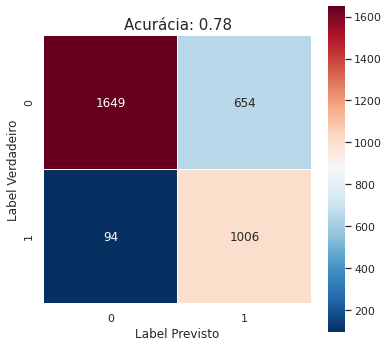

In [18]:
# Criando o modelo

# Selecionando features para treinamento
X = treino.drop(['TARGET'], axis = 1)

# Selecionando feature target
y = treino['TARGET']

# Transformando target em tipo numerico
y = y.astype("category").cat.codes

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X = StandardScaler().fit_transform(X)

# Split dos dados
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = .2, random_state = SEED, stratify = y)    



params = {'silent'       : 1,
          'objective'    : 'binary:logistic',
          'eval_metric'  : 'auc',
          'booster'      : 'gbtree',
          'lambda'       : 0.026834336727892413,
          'alpha'        : 0.0006039910566283139,
          'max_depth'    : 8,
          'eta'          : 0.0006565933008274129,
          'gamma'        : 0.0012661208934645076,
          'grow_policy' : 'depthwise'}


#modelo_xgb_v4 = xgb.XGBClassifier(**study_v2.best_params)
modelo_xgb_v4 = xgb.XGBClassifier(**params)

# Treinando o modelo
modelo_xgb_v4.fit(X_treino, y_treino)

# Fazendo previsões
xgb_y_pred = modelo_xgb_v4.predict(X_teste)
previsoes = [round(value) for value in xgb_y_pred]

# Avaliando as previsões
xgb_score_v4 = accuracy_score(y_teste, previsoes)
print("Acurácia: %.2f%%" % (xgb_score_v4 * 100.0))

# Cria a matriz de confusão
conf_matriz_xgb = confusion_matrix(y_teste, xgb_y_pred)
    
# Calcula especificidade e sensibilidade
speci_xgb = conf_matriz_xgb[0,0] / (conf_matriz_xgb[0,0] + conf_matriz_xgb[0,1])
sensi_xgb = conf_matriz_xgb[1,1] / (conf_matriz_xgb[1,0] + conf_matriz_xgb[1,1])

# Print
print('Sensibilidade :', sensi_xgb)
print('Especificidade :', speci_xgb)
print('\n')

# Matriz de Confusão gráfica
sns.set(rc={'figure.figsize':(6, 6)})
sns.heatmap(conf_matriz_xgb, 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title('Acurácia: {:.2f}'.format(xgb_score_v4), size = 15)

# Relatório de Classificação
print(classification_report(y_teste, xgb_y_pred))

# Parte 05. Realizando novas previsões

In [22]:
# Carregando o dataset de testes 
teste  = pd.read_csv(r'to_be_scored.csv')
print('Quantidade de registros e colunas: ',teste.shape)

# Removendo colunas que não serão utilizadas no treinamento
teste = teste.drop(['Tempo','Estação','Movimentação','LAT','LONG'], axis = 1)

# Visualizando os primeiros registros
teste.head()

Quantidade de registros e colunas:  (984, 13)


,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego
0,22,65,22,14,3,26,43,18
1,11,56,16,14,43,20,37,15
2,86,51,8,11,41,20,35,12
3,76,47,65,11,37,14,32,10
4,68,42,60,6,35,13,26,5


In [23]:
# Padronizando os dados (0 para a média, 1 para o desvio padrão)
teste_scaler = StandardScaler().fit_transform(teste)

# Realizando previsoes com dados de teste(usando modelo NAO BALANCEADO)
y_pred_test = modelo_xgb_v4.predict(teste_scaler)


In [24]:
# Salvando na coluna target
teste['TARGET'] = y_pred_test
teste['TARGET'] = np.where(teste['TARGET'] == 0, 'NORMAL', 'REABASTECER')

# Visualizando os ultimos registros
teste.tail()

,Original_473,Original_269,Zero,Maçã-Verde,Tangerina,Citrus,Açaí-Guaraná,Pêssego,TARGET
979,34,65,28,17,33,27,6,2,REABASTECER
980,21,60,18,15,27,22,43,43,NORMAL
981,9,56,13,14,21,17,37,37,REABASTECER
982,86,49,7,14,17,12,33,33,REABASTECER
983,74,41,65,8,14,7,27,27,NORMAL


,TARGET,%
NORMAL,503,51.118
REABASTECER,481,48.882


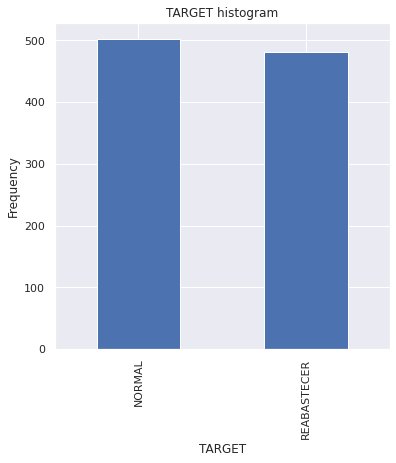

In [25]:
# Visualizando a distribuição das classes (variavel TARGET)
pd.value_counts(teste['TARGET']).plot.bar()
plt.title('TARGET histogram')
plt.xlabel('TARGET')
plt.ylabel('Frequency')

# Visualizando um df com quantidade e percentual da variavel TARGET
tmp = pd.DataFrame(teste['TARGET'].value_counts())
tmp['%'] = round(100*tmp['TARGET']/tmp['TARGET'].sum(),3)
tmp

In [ ]:
# Gravando resultado em csv
teste.to_csv('results_xgb.csv',index=False)